## 생존여부 예측모델 만들기
### 학습용 데이터 (X_train, y_train)을 이용하여 생존 예측 모형을 만든 후, 이를 평가용 데이터(X_test)에 적용하여 얻은 예측값을 다음과 같은 형식의 CSV파일로 생성하시오(제출한 모델의 성능은 accuracy 평가지표에 따라 채점)

(가) 제공 데이터 목록
- y_train: 생존여부(학습용)
- X_trian, X_test : 승객 정보 (학습용 및 평가용)

(나) 데이터 형식 및 내용
- y_trian (712명 데이터)

**시험환경 세팅은 예시문제와 동일한 형태의 X_train, y_train, X_test 데이터를 만들기 위함임**

### 유의사항
- 성능이 우수한 예측모형을 구축하기 위해서는 적절한 데이터 전처리, 피처엔지니어링, 분류알고리즘, 하이퍼파라미터 튜닝, 모형 앙상블 등이 수반되어야 한다.
- 수험번호.csv파일이 만들어지도록 코드를 제출한다.
- 제출한 모델의 성능은 accuracy로 평가함

csv 출력형태

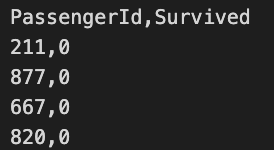

## [참고]작업형2 문구
- 출력을 원하실 경우 print() 함수 활용
- 예시) print(df.head())
- getcwd(), chdir() 등 작업 폴더 설정 불필요
- 파일 경로 상 내부 드라이브 경로(C: 등) 접근 불가

### 데이터 파일 읽기 예제
- import pandas as pd
- X_test = pd.read_csv("data/X_test.csv")
- X_train = pd.read_csv("data/X_train.csv")
- y_train = pd.read_csv("data/y_train.csv")

### 사용자 코딩

### 답안 제출 참고
- 아래 코드 예측변수와 수험번호를 개인별로 변경하여 활용
- pd.DataFrame({'cust_id': X_test.cust_id, 'gender': pred}).to_csv('003000000.csv', index=False)

In [341]:
# 시험환경 세팅 (코드 변경 X)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def exam_data_load(df, target, id_name="", null_name=""):
    if id_name == "":
        df = df.reset_index().rename(columns={"index": "id"})
        id_name = 'id'
    else:
        id_name = id_name
    
    if null_name != "":
        df[df == null_name] = np.nan
    
    X_train, X_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=2021)
    y_train = X_train[[id_name, target]]
    X_train = X_train.drop(columns=[id_name, target])
    y_test = X_test[[id_name, target]]
    X_test = X_test.drop(columns=[id_name, target])
    return X_train, X_test, y_train, y_test 
    
df = pd.read_csv("../input/titanic/train.csv")
X_train, X_test, y_train, y_test = exam_data_load(df, 
                                                  target='Survived', 
                                                  id_name='PassengerId')

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 10), (179, 10), (712, 2), (179, 2))

## Start
### 라이브러리 및 데이터 불러오기


In [342]:
### 라이브러리 및 데이터 불러오기
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [343]:
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
90,3,"Christmann, Mr. Emil",male,29.0,0,0,343276,8.0500,NaN,S
103,3,"Johansson, Mr. Gustaf Joel",male,33.0,0,0,7540,8.6542,NaN,S
577,1,"Silvey, Mrs. William Baird (Alice Munger)",female,39.0,1,0,13507,55.9000,E44,S
215,1,"Newell, Miss. Madeleine",female,31.0,1,0,35273,113.2750,D36,C
191,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S


In [344]:
X_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
210,3,"Ali, Mr. Ahmed",male,24.0,0,0,SOTON/O.Q. 3101311,7.0500,NaN,S
876,3,"Gustafsson, Mr. Alfred Ossian",male,20.0,0,0,7534,9.8458,NaN,S
666,2,"Butler, Mr. Reginald Fenton",male,25.0,0,0,234686,13.0000,NaN,S
819,3,"Skoog, Master. Karl Thorsten",male,10.0,3,2,347088,27.9000,NaN,S
736,3,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48.0,1,3,W./C. 6608,34.3750,NaN,S


In [345]:
y_train.head()

,PassengerId,Survived
90,91,0
103,104,0
577,578,1
215,216,1
191,192,0


### 전처리 및 EDA

In [346]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 90 to 116
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Name      712 non-null    object 
 2   Sex       712 non-null    object 
 3   Age       575 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Ticket    712 non-null    object 
 7   Fare      712 non-null    float64
 8   Cabin     170 non-null    object 
 9   Embarked  711 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 61.2+ KB


In [347]:
X_train.describe()

,Pclass,Age,SibSp,Parch,Fare
count,712.000000,575.000000,712.000000,712.000000,712.000000
mean,2.285112,29.414783,0.533708,0.391854,33.388155
std,0.842875,14.589601,1.099284,0.802311,50.807818
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,1.000000,20.000000,0.000000,0.000000,7.925000
50%,3.000000,28.000000,0.000000,0.000000,15.047900
75%,3.000000,37.000000,1.000000,0.000000,31.387500
max,3.000000,74.000000,8.000000,6.000000,512.329200


In [348]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 210 to 45
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    179 non-null    int64  
 1   Name      179 non-null    object 
 2   Sex       179 non-null    object 
 3   Age       139 non-null    float64
 4   SibSp     179 non-null    int64  
 5   Parch     179 non-null    int64  
 6   Ticket    179 non-null    object 
 7   Fare      179 non-null    float64
 8   Cabin     34 non-null     object 
 9   Embarked  178 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 15.4+ KB


Age, Cabin, Embarked에 결측치 존재

결측치가 너무 많은 Cabin은 제거

In [349]:
temp = X_train.copy()
temp['target'] = y_train.iloc[:,1]

In [350]:
temp.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,target
90,3,"Christmann, Mr. Emil",male,29.0,0,0,343276,8.0500,NaN,S,0
103,3,"Johansson, Mr. Gustaf Joel",male,33.0,0,0,7540,8.6542,NaN,S,0
577,1,"Silvey, Mrs. William Baird (Alice Munger)",female,39.0,1,0,13507,55.9000,E44,S,1
215,1,"Newell, Miss. Madeleine",female,31.0,1,0,35273,113.2750,D36,C,1
191,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S,0


In [351]:
temp['Embarked'].describe()

count     711
unique      3
top         S
freq      514
Name: Embarked, dtype: object

In [352]:
temp['Embarked'] = temp['Embarked'].fillna('S') # 최빈값 대체

In [353]:
temp.groupby(['Pclass', 'Sex']).median()['Age'] # 클래스별 차이가 있으므로 해당 중위값으로 대체

Pclass  Sex   
1       female    35.0
        male      38.0
2       female    30.0
        male      30.0
3       female    19.0
        male      25.0
Name: Age, dtype: float64

In [354]:
temp.loc[(temp['Pclass']==1)&(temp['Sex']=='female')&(temp['Age'].isna()),'Age'] = 35
temp.loc[(temp['Pclass']==1)&(temp['Sex']=='male')&(temp['Age'].isna()),'Age'] = 38
temp.loc[(temp['Pclass']==2)&(temp['Sex']=='female')&(temp['Age'].isna()),'Age'] = 30
temp.loc[(temp['Pclass']==2)&(temp['Sex']=='male')&(temp['Age'].isna()),'Age'] = 30
temp.loc[(temp['Pclass']==3)&(temp['Sex']=='female')&(temp['Age'].isna()),'Age'] = 19
temp.loc[(temp['Pclass']==3)&(temp['Sex']=='male')&(temp['Age'].isna()),'Age'] = 25

In [355]:
temp = pd.concat([temp, pd.get_dummies(temp.Sex).iloc[:,:-1]], axis = 1)
temp = pd.concat([temp, pd.get_dummies(temp.Embarked).iloc[:,:-1]], axis = 1)

temp.drop(['Name', 'Cabin', 'Sex', 'Embarked', 'Ticket'],axis=1, inplace=True)

In [356]:
X_test['Embarked'] = X_test['Embarked'].fillna('S')

X_test.loc[(X_test['Pclass']==1)&(X_test['Sex']=='female')&(X_test['Age'].isna()),'Age'] = 35
X_test.loc[(X_test['Pclass']==1)&(X_test['Sex']=='male')&(X_test['Age'].isna()),'Age'] = 38
X_test.loc[(X_test['Pclass']==2)&(X_test['Sex']=='female')&(X_test['Age'].isna()),'Age'] = 30
X_test.loc[(X_test['Pclass']==2)&(X_test['Sex']=='male')&(X_test['Age'].isna()),'Age'] = 30
X_test.loc[(X_test['Pclass']==3)&(X_test['Sex']=='female')&(X_test['Age'].isna()),'Age'] = 19
X_test.loc[(X_test['Pclass']==3)&(X_test['Sex']=='male')&(X_test['Age'].isna()),'Age'] = 25

X_test = pd.concat([X_test, pd.get_dummies(X_test.Sex).iloc[:,:-1]], axis = 1)
X_test = pd.concat([X_test, pd.get_dummies(X_test.Embarked).iloc[:,:-1]], axis = 1)

X_test.drop(['Name', 'Cabin', 'Sex', 'Embarked' ,'Ticket'], axis=1, inplace=True)

In [357]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 90 to 116
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  712 non-null    int64  
 1   Age     712 non-null    float64
 2   SibSp   712 non-null    int64  
 3   Parch   712 non-null    int64  
 4   Fare    712 non-null    float64
 5   target  712 non-null    int64  
 6   female  712 non-null    uint8  
 7   C       712 non-null    uint8  
 8   Q       712 non-null    uint8  
dtypes: float64(2), int64(4), uint8(3)
memory usage: 41.0 KB


In [358]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 210 to 45
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  179 non-null    int64  
 1   Age     179 non-null    float64
 2   SibSp   179 non-null    int64  
 3   Parch   179 non-null    int64  
 4   Fare    179 non-null    float64
 5   female  179 non-null    uint8  
 6   C       179 non-null    uint8  
 7   Q       179 non-null    uint8  
dtypes: float64(2), int64(3), uint8(3)
memory usage: 8.9 KB


In [359]:
temp.describe()

,Pclass,Age,SibSp,Parch,Fare,target,female,C,Q
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,2.285112,28.763343,0.533708,0.391854,33.388155,0.380618,0.352528,0.198034,0.078652
std,0.842875,13.436188,1.099284,0.802311,50.807818,0.485880,0.478093,0.398798,0.269384
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,20.000000,0.000000,0.000000,7.925000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,26.000000,0.000000,0.000000,15.047900,0.000000,0.000000,0.000000,0.000000
75%,3.000000,36.000000,1.000000,0.000000,31.387500,1.000000,1.000000,0.000000,0.000000
max,3.000000,74.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000


In [360]:
X_test.describe()

,Pclass,Age,SibSp,Parch,Fare,female,C,Q
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000
mean,2.402235,29.702067,0.480447,0.340782,27.494878,0.351955,0.150838,0.117318
std,0.803920,12.995215,1.118490,0.821797,44.811156,0.478920,0.358895,0.322702
min,1.000000,0.670000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000
50%,3.000000,26.000000,0.000000,0.000000,13.000000,0.000000,0.000000,0.000000
75%,3.000000,38.000000,1.000000,0.000000,28.918750,1.000000,0.000000,0.000000
max,3.000000,80.000000,8.000000,5.000000,512.329200,1.000000,1.000000,1.000000


In [361]:
temp.groupby('target').mean()

,Pclass,Age,SibSp,Parch,Fare,female,C,Q
target,,,,,,,,
0,2.514739,29.520408,0.544218,0.317460,22.523278,0.136054,0.140590,0.083900
1,1.911439,27.531365,0.516605,0.512915,51.068636,0.704797,0.291513,0.070111


- 사망 : 남성, 클래스가 낮을수록, 요금이 쌀수록 사망비율이 높다.
- 생존 : 여성, 클래스가 높을수록, 요금이 비쌀수록 생존비율이 높다.

In [362]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBRFClassifier, XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [363]:
X_tra, X_val, y_tra, y_val = train_test_split(temp.drop('target',axis=1), temp.target, test_size=0.2, random_state=42)

In [364]:
list_ml = [AdaBoostClassifier(random_state=42), GradientBoostingClassifier(random_state=42), 
           RandomForestClassifier(random_state=42), ExtraTreesClassifier(random_state=42),
           SVC(random_state=42), DecisionTreeClassifier(random_state=42), XGBRFClassifier(random_state=42), XGBClassifier(random_state=42)]

In [365]:
for i in range(len(list_ml)):
    clf = list_ml[i]
    clf.fit(X_tra, y_tra)
    print(list_ml[i],':', clf.score(X_val, y_val))

AdaBoostClassifier(random_state=42) : 0.7972027972027972
GradientBoostingClassifier(random_state=42) : 0.8671328671328671
RandomForestClassifier(random_state=42) : 0.8391608391608392
ExtraTreesClassifier(random_state=42) : 0.8181818181818182
SVC(random_state=42) : 0.6713286713286714
DecisionTreeClassifier(random_state=42) : 0.8041958041958042


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:42:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, enable_categorical=False, gamma=0,
                gpu_id=-1, importance_type=None, interaction_constraints='',
                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=4,
                num_parallel_tree=100, objective='binary:logistic',
                predictor='auto', random_state=42, reg_alpha=0,
                scale_pos_weight=1, tree_method='exact', validate_parameters=1,
                verbosity=None) : 0.8461538461538461
[12:42:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with th

- GradientBoostingClassifier(random_state=42) : 0.8671328671328671
- RandomForestClassifier(random_state=42) : 0.8391608391608392
- XGBRFClassifier() : 0.8461538461538461

상위 3개의 모델의 최적 하이퍼파라미터를 찾기로 한다.

In [366]:
X_train = temp.drop('target',axis=1)
y_train = temp.target

In [367]:
parameters = {'learning_rate':[0.01, 0.005], 'n_estimators':[100,300,500]}
clf = GridSearchCV(GradientBoostingClassifier(random_state=42), parameters)
clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_score_)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=500,
                           random_state=42)
0.8328769821727569


In [368]:
parameters = {'max_depth':[-1,5,10], 'n_estimators':[100,300,500]}
clf = GridSearchCV(RandomForestClassifier(random_state=42), parameters)
clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_score_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/python3.7/site-packages/jobli

RandomForestClassifier(max_depth=10, n_estimators=500, random_state=42)
0.8483305426967398


In [369]:
parameters = {'max_depth':[-1,5,10], 'learning_rate':[0.01, 0.005], 'n_estimators':[100,300,500]}
clf = GridSearchCV(XGBRFClassifier(random_state=42), parameters)
clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_score_)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 506, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/pyth

[12:43:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

0.8483305426967398으로 가장 점수가 높은 RandomForestClassifier(max_depth=10, n_estimators=500, random_state=42)을 최종모델 선정

In [370]:
clf = RandomForestClassifier(max_depth=10, n_estimators=500, random_state=42)
clf.fit(X_train, y_train)
pred = y_test.copy()
pred.iloc[:,1] = clf.predict(X_test)

In [371]:
print('최종 스코어 :', accuracy_score(pred.iloc[:,1], y_test.iloc[:,1]))

최종 스코어 : 0.770949720670391


In [372]:
# pred.to_csv('titanic.csv', index = False)

## kaggle code

## 라이브러리 및 데이터 불러오기

In [373]:
# 시험환경 세팅 (코드 변경 X)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def exam_data_load(df, target, id_name="", null_name=""):
    if id_name == "":
        df = df.reset_index().rename(columns={"index": "id"})
        id_name = 'id'
    else:
        id_name = id_name
    
    if null_name != "":
        df[df == null_name] = np.nan
    
    X_train, X_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=2021)
    y_train = X_train[[id_name, target]]
    X_train = X_train.drop(columns=[id_name, target])
    y_test = X_test[[id_name, target]]
    X_test = X_test.drop(columns=[id_name, target])
    return X_train, X_test, y_train, y_test 
    
df = pd.read_csv("../input/titanic/train.csv")
X_train, X_test, y_train, y_test = exam_data_load(df, 
                                                  target='Survived', 
                                                  id_name='PassengerId')

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 10), (179, 10), (712, 2), (179, 2))

In [374]:
# 라이브러리 불러오기
import pandas as pd

In [375]:
# 데이터 불러오기 (생략)
X_train.shape, y_train.shape, X_test.shape

((712, 10), (712, 2), (179, 10))

## EDA

In [376]:
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
90,3,"Christmann, Mr. Emil",male,29.0,0,0,343276,8.0500,NaN,S
103,3,"Johansson, Mr. Gustaf Joel",male,33.0,0,0,7540,8.6542,NaN,S
577,1,"Silvey, Mrs. William Baird (Alice Munger)",female,39.0,1,0,13507,55.9000,E44,S
215,1,"Newell, Miss. Madeleine",female,31.0,1,0,35273,113.2750,D36,C
191,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S


In [377]:
# float64(2), int64(3), object(5)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 90 to 116
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Name      712 non-null    object 
 2   Sex       712 non-null    object 
 3   Age       575 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Ticket    712 non-null    object 
 7   Fare      712 non-null    float64
 8   Cabin     170 non-null    object 
 9   Embarked  711 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 61.2+ KB


In [378]:
y_train.head()

,PassengerId,Survived
90,91,0
103,104,0
577,578,1
215,216,1
191,192,0


In [379]:
# 생존 비율
y_train['Survived'].value_counts()

0    441
1    271
Name: Survived, dtype: int64

## 데이터 전처리

In [380]:
y = y_train["Survived"]

# sex만 원핫인코딩 됨
features = ["Pclass", "Sex", "SibSp", "Parch"]
X_train = pd.get_dummies(X_train[features])
X_test = pd.get_dummies(X_test[features])

In [381]:
X_train.shape, X_test.shape

((712, 5), (179, 5))

In [382]:
X_train.head()

,Pclass,SibSp,Parch,Sex_female,Sex_male
90,3,0,0,0,1
103,3,0,0,0,1
577,1,1,0,1,0
215,1,1,0,1,0
191,2,0,0,0,1


## 모델 및 평가

In [383]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=2021)
model.fit(X_train, y)
predictions = model.predict(X_test)

In [384]:
model.score(X_train, y)

0.8356741573033708

In [385]:
output = pd.DataFrame({'PassengerId': y_test.PassengerId, 'Survived': predictions})
output.head()

,PassengerId,Survived
210,211,0
876,877,0
666,667,0
819,820,0
736,737,0


In [386]:
# 수험번호.csv로 출력
output.to_csv('1234567.csv', index=False)

## 결과 체점 (수험자는 알 수 없는 부분임)

In [387]:
model.score(X_test, y_test['Survived'])

0.7318435754189944